In [220]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.signal import stft
import matplotlib.pyplot as plt
from neurodsp.utils import create_times

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 샘플 데이터 생성
fpath = "../../data/DNN_data/v3/"

sig_with_artifact = np.load(fpath + "data_with_artifact_test" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

x_data = sig_with_artifact
y_data = sig

print(x_data.shape)
print(y_data.shape)

cuda:0
(1000, 4000)
(1000, 4000)


In [221]:
fs = 2000
num_signals = 1000
n_seconds = 2
times = create_times(n_seconds, fs)

fft_win_time = 0.5  # 윈도우 길이 (초)
n_fft = int(fft_win_time * fs)  # FFT 윈도우 크기, 1000 샘플
fft_overlap_time = int(fft_win_time / 2 * fs)  # 오버랩 크기, 500 샘플, 50%
freqs = torch.fft.rfftfreq(n_fft, 1 / fs) # 주파수 대역

In [222]:
# stft
x_stft = []
x_stft_2 =[]
def compute_stft(data, fs, fft_win_time):
    n_fft = int(fft_win_time * fs)
    fft_overlap_time = int(fft_win_time / 2 * fs)
    
    stft_results = []
    for sample in data:
        # torch.tensor로 변환할 때 dtype=torch.float32로 명시적으로 지정
        sample_tensor = torch.tensor(sample, dtype=torch.float32)
        Zxx = torch.stft(sample_tensor, n_fft, hop_length=n_fft - fft_overlap_time, return_complex=True)
        stft_results.append(Zxx)

    # 넘파이 배열로 변환
    stft_results_np = np.array(stft_results)
    
    return stft_results_np

x_stft = compute_stft(x_data, fs, fft_win_time)
y_stft = compute_stft(y_data, fs, fft_win_time)

# print(f"x_data shape: {x_data.shape}") # (1000, 4000)
# print(f"x_stft shape: {x_stft.shape}") # (1000, 501, 9)
# print(f"x_stft_2 shape: {x_stft_2.shape}") # (1000, 501, 9, 2)
# print(f"y_data shape: {y_data.shape}") # (1000, 4000)
# print(f"y_stft shape: {y_stft.shape}") # (1000, 501, 9)

print(f"x_stft: {x_stft[0][0]}")
print(f"y_stft: {y_stft[0][0][0]}")

# 각 요소는 (frequency_bins, time_frames, 2)의 복소수(2; 실수, 허수 성분) 텐서입니다.
# x_data[0] shape: (4000,)
# x_stft[0] shape: (1000, 501, 9)

# log10 씌워주기
x_stft = np.log10(np.abs(x_stft)**2 + 1e-6)
y_stft = np.log10(np.abs(y_stft)**2 + 1e-6)

x_stft: [  505.7691 +0.j  1306.8297 +0.j  1027.0393 +0.j  -143.7783 +0.j
   157.88266+0.j   435.17474+0.j   282.8852 +0.j  -930.9418 +0.j
 -2116.931  +0.j]
y_stft: (-3.471951484680176+0j)


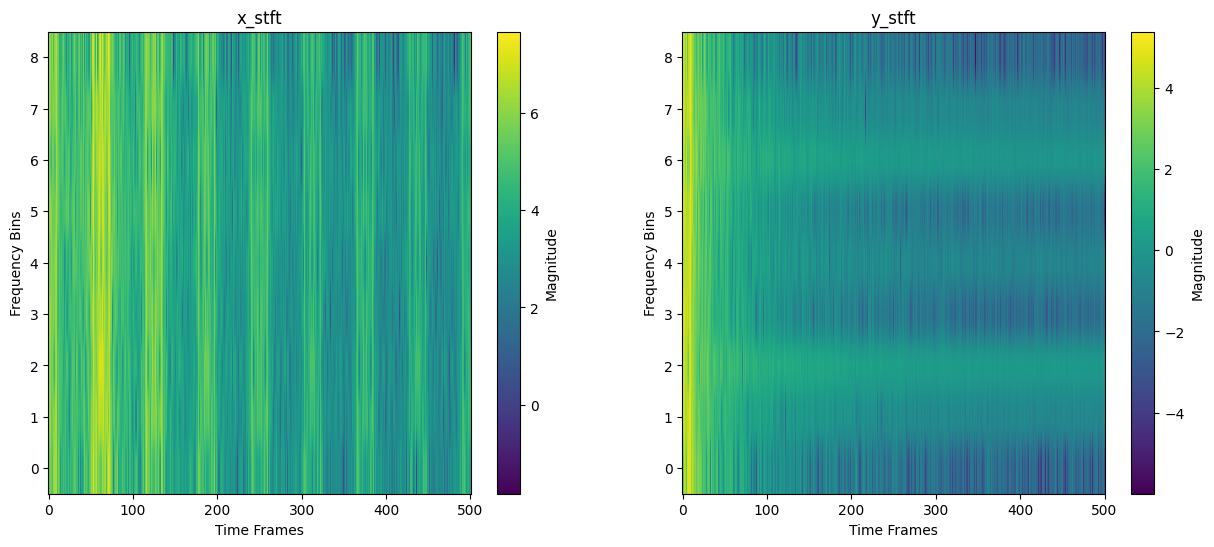

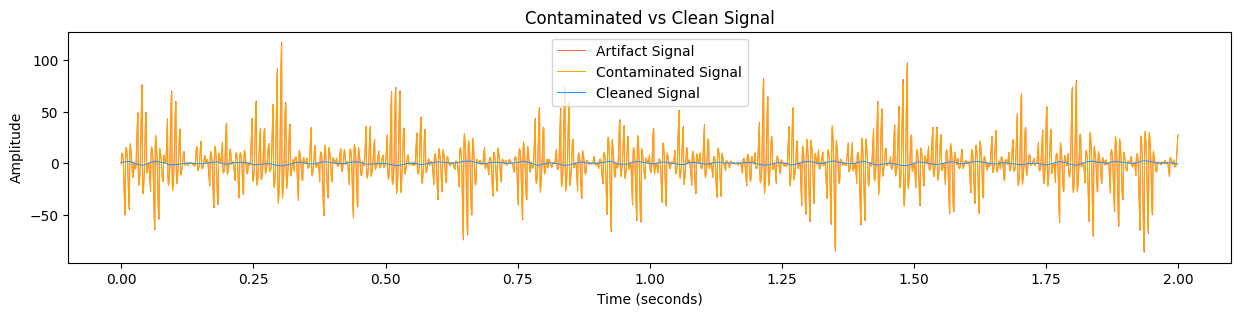

<Figure size 640x480 with 0 Axes>

In [223]:
# 2D spectrogram
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_stft[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('x_stft')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(1, 2, 2)
plt.imshow(y_stft[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('y_stft')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.figure(figsize=(15, 3))
plt.plot(times, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(times, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(times, sig[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

plt.tight_layout()
plt.show()


In [224]:
# # power spectrum
# power_spectrum = np.abs(Zxx) ** 2  # 파워 스펙트럼 계산

In [225]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()

# X = scaler.fit_transform(x_stft.T)
# Y = (y_stft.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

# X = X.T
# Y = Y.T

# print(X.shape)
# print(Y.shape) 

In [226]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(x_stft, y_stft, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 501, 9), y_train shape: (800, 501, 9)
X_test shape: (200, 501, 9), y_test shape: (200, 501, 9)
unsqueezed X_train shape: (800, 1, 501, 9), y_train shape: (800, 501, 9)
unsqueezed X_test shape: (200, 1, 501, 9), y_test shape: (200, 501, 9)


In [227]:
# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=1, padding="same")
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(3, 3), stride=1, padding="same")
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
)


In [228]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x F x T
        y = batch[1] # y : B x 1 x F x T
        x, y = x.to(device), y.to(device)
        x, y = x.type(torch.float32), y.type(torch.float32)
        x, y = torch.log10(torch.abs(x)**2 + 1e-6), torch.log10(torch.abs(y)**2 + 1e-6)
        
        y_pred = model(x) # y_pred : B x F x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32, 501, 9])) that is different to the input size (torch.Size([32, 1, 501, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/200, Loss: 1.2713165283203125
Epoch 10/200, Loss: 1.3210480213165283
Epoch 15/200, Loss: 1.2535063028335571
Epoch 20/200, Loss: 1.3055475950241089
Epoch 25/200, Loss: 1.3542726039886475
Epoch 30/200, Loss: 1.3167023658752441
Epoch 35/200, Loss: 1.3760429620742798
Epoch 40/200, Loss: 1.3412193059921265
Epoch 45/200, Loss: 1.3448257446289062
Epoch 50/200, Loss: 1.3531179428100586
Epoch 55/200, Loss: 1.296455979347229
Epoch 60/200, Loss: 1.3523519039154053
Epoch 65/200, Loss: 1.244073748588562
Epoch 70/200, Loss: 1.3435546159744263
Epoch 75/200, Loss: 1.3194502592086792
Epoch 80/200, Loss: 1.2753781080245972
Epoch 85/200, Loss: 1.3135262727737427
Epoch 90/200, Loss: 1.2809175252914429
Epoch 95/200, Loss: 1.3656541109085083
Epoch 100/200, Loss: 1.3273046016693115
Epoch 105/200, Loss: 1.3061481714248657
Epoch 110/200, Loss: 1.2959003448486328
Epoch 115/200, Loss: 1.3021286725997925
Epoch 120/200, Loss: 1.3939423561096191
Epoch 125/200, Loss: 1.3608322143554688
Epoch 130/200, Loss: 1

In [229]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x 1 x F x T
        y = batch[1] # y : B x 1 x F x T 
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x 1 x F x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 2.095118999481201


c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([200, 1, 501, 9])) that is different to the input size (torch.Size([200, 501, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


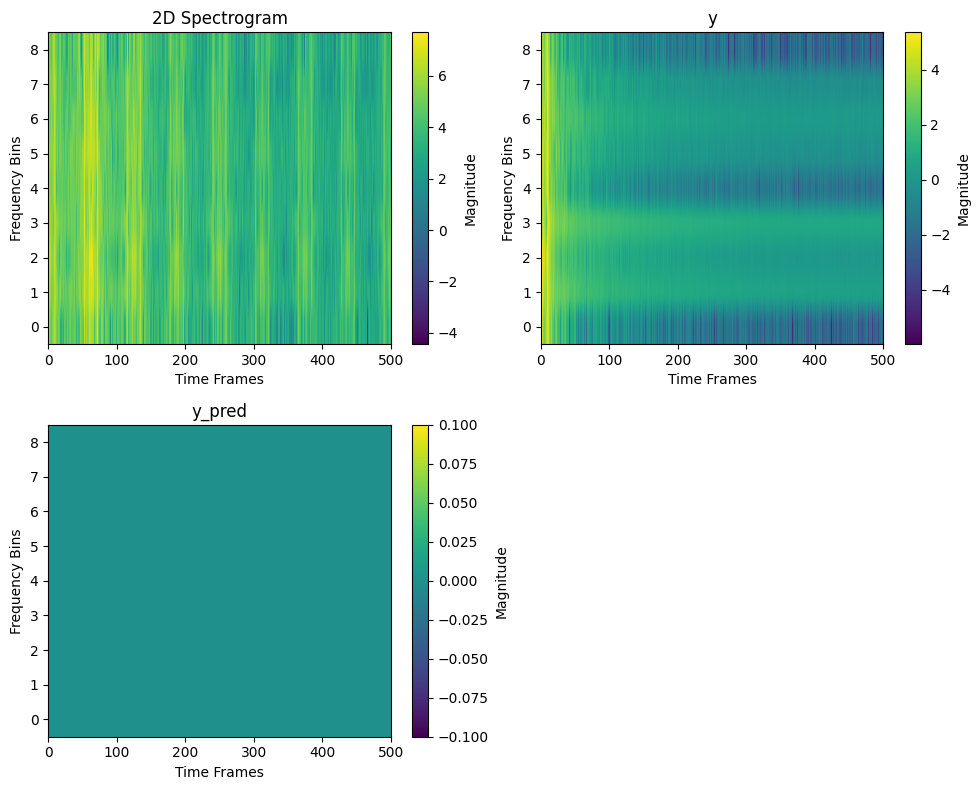

In [230]:
# 2D spectrogram
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(Contaminated[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(2, 2, 2)
plt.imshow(Clean[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('y')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(2, 2, 3)
plt.imshow(SACed[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('y_pred')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.tight_layout()
plt.show()
